In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from utils import data_dir

from tqdm import tqdm
from tabulate import tabulate

In [3]:
import sys
sys.version

'3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]'

In [4]:
task_name = "axion2"
model_layer = "Sigma"

## Grab our data

In [5]:
pfn_outputs = np.load(f"pfn_layer_outputs/{task_name}_{model_layer}_10%.npy")
pfn_outputs = pfn_outputs.T

# Stylize these labels for the sake of LaTeX
if "_" in model_layer:
    part, idx = model_layer.split("_")  # Something like ("F", "7")
    model_layer = f"{part}{idx}"
pfn_labels = [f"{model_layer}({i})" for i in range(pfn_outputs.shape[0])]

print("PFN outputs shape:", pfn_outputs.shape)

PFN outputs shape: (128, 30000)


In [6]:
bdt_vars = []
for particle in ["pi0", "gamma", task_name]:
    bdt_var_npz = np.load(f"{data_dir}/processed/bdt_vars/{particle}_bdt_vars.npz")
    bdt_var_labels = list(bdt_var_npz.keys())
    bdt_vars.append(np.vstack([bdt_var_npz[key] for key in bdt_var_labels])[:,::10])

bdt_vars = np.hstack(bdt_vars)
print("BDT vars shape: ", bdt_vars.shape)

BDT vars shape:  (53, 30000)


In [7]:
# Mask out things that are all zeros
def filter_zero_var(arr, labels):
    """
    arr.shape == (n_features, n_samples)
    len(labels) == n_features
    
    Filter out all features having zero variance.
    """
    # Filter for zero variance
    all_zero_mask = np.nanvar(arr, axis=1) < 1e-6
    return (
        arr[~all_zero_mask],
        [labels[i] for i in np.where(~all_zero_mask)[0]],
        all_zero_mask
    )

pfn_outputs, pfn_labels, _ = filter_zero_var(pfn_outputs, pfn_labels)
bdt_vars, bdt_var_labels, _ = filter_zero_var(bdt_vars, bdt_var_labels)

In [8]:
all_vars = np.vstack([pfn_outputs, bdt_vars])
all_labels = pfn_labels + bdt_var_labels

# Impute missing values
nan_locs = np.where(np.isnan(all_vars))
for feature, sample in zip(*nan_locs):
    all_vars[feature,sample] = np.nanmean(all_vars[feature,:])
    
assert not np.any(np.isnan(all_vars))

In [9]:
print(all_vars.shape)

(162, 30000)


## Evaluate correlations

In [10]:
# Wooooo...
corr_mat = np.corrcoef(all_vars)

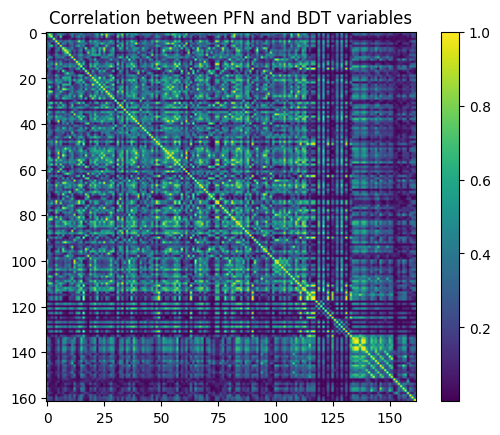

In [11]:
plt.imshow(np.abs(corr_mat))
plt.colorbar()
plt.title(f"Correlation between PFN and BDT variables");

There's a couple variables with zero variance amongst the BDT variables, but that's ok.

In [12]:
def get_corr(var1, var2):
    return corr_mat[all_labels.index(var1),all_labels.index(var2)]

In [13]:
# Stylize labels with LaTeX
def stylize(label):
    if label.startswith("F"):
        if len(label) > 2:  # Unit
            F_layer = label[1]
            unit_idx = label[3:-1]
            return "$F^{[" + F_layer + "]}_{" + unit_idx + "}$"
        else:
            F_layer = label[1]
            return "$F^{[" + F_layer + "]}$"
        
    if label.startswith("Sigma"):
        unit_idx = label.removeprefix("Sigma(").removesuffix(")")
        return "$\Sigma_{" + unit_idx + "}$"
        
    return label

In [14]:
def plot_corr(var1, var2, title=True):
    idx1, idx2 = all_labels.index(var1), all_labels.index(var2)
    plt.scatter(all_vars[idx1], all_vars[idx2], s=0.1, linewidth=0)
    
    plt.xlabel(stylize(var1))
    plt.ylabel(stylize(var2))
    if title: plt.title(f"{task_name} PFN, layer {stylize(model_layer)}")

## For each BDT variable, find which PFN var it correlates most highly with

In [21]:
corrs = {}
for var1 in bdt_var_labels:
    idx1 = all_labels.index(var1)
    idx2 = np.argmax(corr_mat[idx1,:len(pfn_labels)])
    var2 = all_labels[idx2]
    corr = corr_mat[idx1,idx2]
    corrs[var1] = (var2, corr)

In [22]:
chosen = [
    "depth_weighted_total_e",
    "depth_weighted_total_e2",
    "secondlayer_x2",
    "secondlayer_y2",
    "prelayer_e",
    "total_e"
]
pairs = [(corrs[bdt_var][0], bdt_var) for bdt_var in chosen]

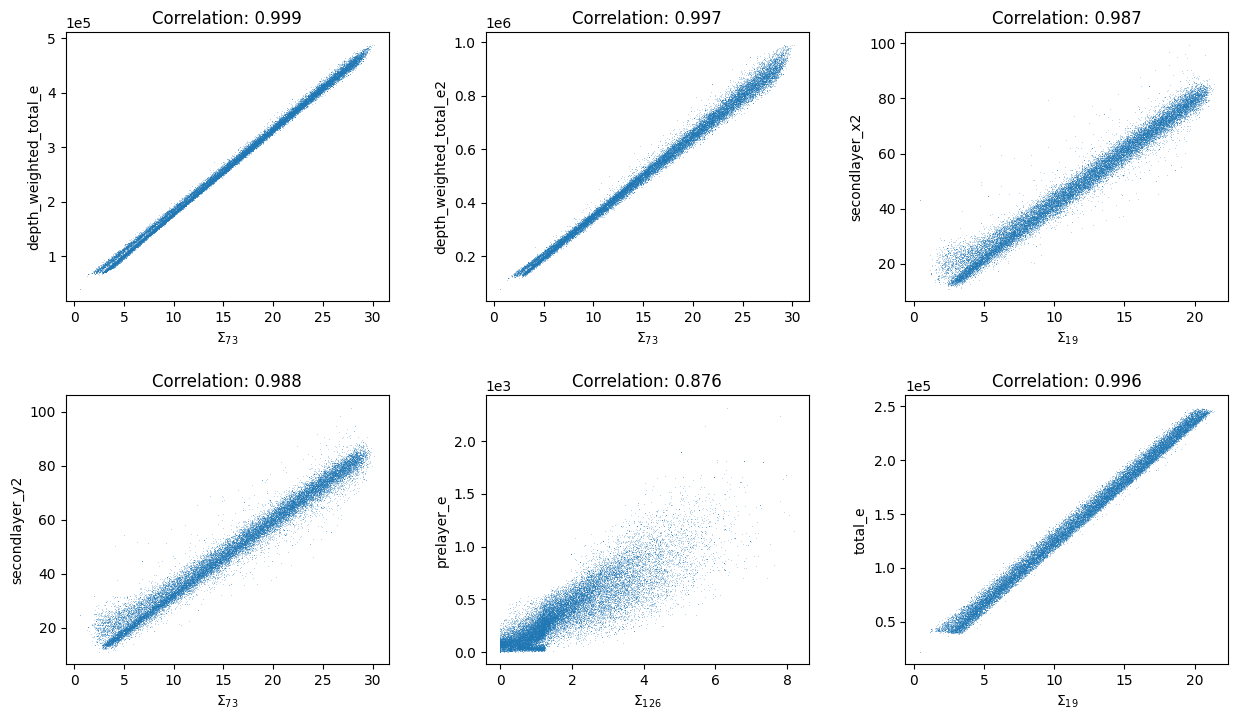

In [24]:
n_cols = 3
n_rows = -(-len(pairs) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.35)
# plt.suptitle(f"{task_name} PFN, layer {stylize(model_layer)}", fontsize="xx-large")
# plt.tight_layout()

# https://stackoverflow.com/questions/8248467/tight-layout-doesnt-take-into-account-figure-suptitle
plt.subplots_adjust(top=0.9)

for row in range(n_rows):
    for col in range(n_cols):
        i = row*n_cols + col        
        if i < len(pairs):
            pair = pairs[i]
            var1, var2 = pair
            plt.axes(axes[i//n_cols,i%n_cols])
            plt.title(f"Correlation: {get_corr(var1, var2):.3f}")
            plt.ticklabel_format(axis="y", style="sci", scilimits=(0,3))
            plot_corr(var1, var2, title=False)
        else:
            fig.delaxes(axes[row,col])